# Navigation with DeepQ-Network

---

In this project, we use the Unity ML-Agents environment to demonstrate how DeepQ-Network can be used to solve navigation problems. This is the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). Make sure you follow the steps outlined in the README file to set up the necessary packages and environment.


### 1. Start the Environment

We begin by importing some necessary packages. 

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque

import random
import torch

import matplotlib.pyplot as plt
%matplotlib inline


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

The problem is solved when we have achieved an average score of more than 13 in the last 100 episodes.

The cell below prints some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. DeepQ-Network Agent

#### Key Concept:

For this reinforcement learning problem, our goal is to find the best action given the current state. Normally for a problem with few states and actions, we can capture the entire state-action interaction in a single table and simply select our actions accordingly. However, in the navigation problem, the states are much more complex. 

To solve this problem, in this project, we use a deep neural network to model the Q value for a given state and action. 

#### Deep Neural Net

For this project we are using a simple deep neural net with 2 hidden layers, each with 64 units in each layer. We used a Relu transformation after each of the hidden layers. Our final ouput layer has 4 output units, one corresponding to each possible actions. The inputs to this neural net is a state, with input size of 37. 

More complex models can be used. The current model does very well in solving the problem. For more details, see `model.py`

#### DeepQ-Network Agent

The way a DeepQ-Network Agent (DQNA) works is by taking a random batch of sampled of states, actions and corresponding rewards and update the weights in the neural network according new insights gained from this new batch. More specifically:

1. Relay Buffer:
Instead of using (state, action, reward) tuples in their natural order, our agent stores a bunch of such tuples in a relay buffer. In each iteration, at each time step, the agent will put the new (state, action, reward) tuple in to the buffer and pull out a random batch of tuples to update the Q-network

2. Target Q vs. Current Q:
At each step, instead of updating the current network according to values in the current network, we use a target network that only gets updated to the current network every few iterations. This prevents the Q-network from chasing after a moving target and helps the agent to learn better.
  
For more information on DQNA, please see `dqn_agent.py`

### 4. Training DQNA

To deploy our agent to solve the navigation problem, we first import the agent class we wrote. The key hyper-parameters can be set in the next cell. 

In [5]:
from dqn_agent import Agent

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor  
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the target network to be the same as current network
fc1_units = 64          # the number of units in the first fully connected hidden layer
fc2_units = 64          # the number of units in the second fully connected hidden layer

seed = 0


Initialize our agent

In [6]:
agent = Agent(state_size, action_size, seed, BUFFER_SIZE, BATCH_SIZE, GAMMA, TAU, LR, UPDATE_EVERY, fc1_units, fc2_units, dropout_prob=0.5)

Run the agent for 2000 episodes, or until the problem is solved.

In [7]:

def dqn(n_episodes=3000, max_t=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        # for each episode, reset our learning enviroment, remember to set train_mode to True for training        
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        
        score = 0
        for t in range(max_t):         
            
            #Take an action with agent, we use epsilon greedy policy when selecting an action
            action = agent.act(state, eps)
            #Update the environment with our chosen action, and obtain the associated next_state, reward, done status
            env_info = env.step(np.int32(action))[brain_name] 
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0] 
            done  = env_info.local_done[0]   
            
            # The agent will then update the current network after a forward pass and then back-propagation of the deep network
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            if done:
                break 
        
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        #the criteria is having score of at least 13 in the past 100 episodes
        if np.mean(scores_window)>=13:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn(2000)



Episode 100	Average Score: 1.06
Episode 200	Average Score: 4.71
Episode 300	Average Score: 8.63
Episode 400	Average Score: 11.05
Episode 474	Average Score: 13.04
Environment solved in 374 episodes!	Average Score: 13.04


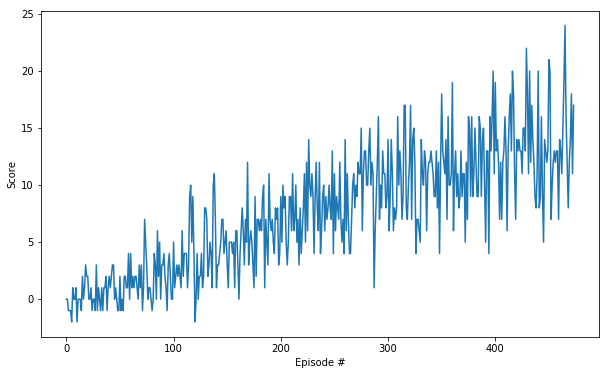

In [8]:
# plot the scores

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Observe trained agent

After successfully training agent and storing the weights, we can see it in action by running the following cell. We can then see the agent collecting yellow bananas while avoiding blue ones. Since we are not training our agent anymore, turn the train_mode to False.

In [9]:

# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(3):
    
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]

    score = 0

    for j in range(1000):
        action = agent.act(state)
        env_info = env.step(np.int32(action))[brain_name]
        next_state = env_info.vector_observations[0] 
        reward = env_info.rewards[0] 
        done = env_info.local_done[0]
        score += reward
        state = next_state 
        if done:
            break 
    
    print("episode:", i+1, ", score:", score )
            

episode: 1 , score: 18.0
episode: 2 , score: 15.0
episode: 3 , score: 20.0


When finished, you can close the environment.

In [10]:
env.close()

### 6. Future Improvements

There are a few ways this DQN model can be improved. 

1. The Deep Neural Net model has not been optimized. We did not experiement with a wide range of hype-parameters to pick and choose the best assumptions that optimize this problem.  
  
2. Use Double DQN design:  
Using the normal DQN model may lead to overestimates because at each step we are using the maximum reward as indicated in the target network. One possible way to combat this is to use current network to select the best action instead and then find the value correspond to that action in the target network. Implementing this small change would improve the performance.
  
3. Prioritized Experience Replay:  
In our set-up, we sample tuples from experience buffer randomly so each tuple has equal probability of getting picked by our model. However, the trueth is that some experience is more important than others. There are ways to sample bufferred experience so that the more important ones -the ones with larger error size- would get sampled with higher probability. 
    
4. Dueling DQN:  
This model changes the deep neural net to contain a dueling architecture such that one branch of the network estimates the state value while the other estimates the advantage of choosing this action over the others.   
  
5. Others: There are other changes that can be applied to the DeepQ-Network to futher improvement its performance. One of the best performing adjustment is the Rainbow design that uses a combination of other adjustments. Please for more information.
  
